In [10]:
import copy
import math
import os
import warnings
from functools import partial

import arviz as az
import beanmachine
import beanmachine.ppl as bm
import beanmachine.ppl.experimental.gp as bgp
import gpytorch
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.distributions as dist
from beanmachine.ppl.experimental.gp.models import SimpleGP
from gpytorch.distributions import MultivariateNormal
from gpytorch.kernels import Kernel
from IPython.display import Markdown

In [11]:
# Eliminate excess UserWarnings from Python.
warnings.filterwarnings("ignore")

# Manual seed
torch.manual_seed(123)

# Other settings for the notebook.
smoke_test = "SANDCASTLE_NEXUS" in os.environ or "CI" in os.environ

# Tool versions
print("pytorch version: ", torch.__version__)
print("gpytorch version: ", gpytorch.__version__)

pytorch version:  1.11.0+cu102
gpytorch version:  1.7.0


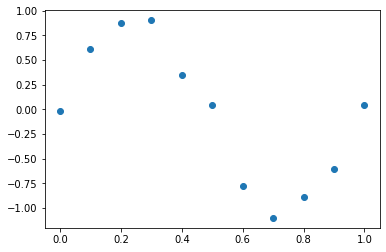

In [12]:
x_train = torch.linspace(0, 1, 11)
y_train = torch.sin(x_train * (2 * math.pi)) + torch.randn(x_train.shape) * 0.2
x_test = torch.linspace(0, 1, 51).unsqueeze(-1)

with torch.no_grad():
    plt.scatter(x_train.numpy(), y_train.numpy())
    plt.show()

In [13]:
class Regression(SimpleGP):
    def __init__(self, x_train, y_train, mean, kernel, likelihood, *args, **kwargs):
        super().__init__(x_train, y_train, mean, kernel, likelihood)

    def forward(self, data, batch_shape=()):
        """
        Computes the GP prior given data. This method should always
        return a `torch.distributions.MultivariateNormal`
        """
        shape = data.shape[len(batch_shape)]
        jitter = torch.eye(shape, shape) * 1e-5
        for _ in range(len(batch_shape)):
            jitter = jitter.unsqueeze(0)
        if isinstance(self.mean, gpytorch.means.Mean):
            # demo using gpytorch for MAP estimation
            mean = self.mean(data)
        else:
            # use Bean Machine for learning posteriors
            if self.training:
                mean = self.mean(batch_shape).expand(data.shape[len(batch_shape) :])
            else:
                mean = self.mean.expand(data.shape[:-1])  # overridden for evaluation
        cov = self.kernel(data) + jitter
        return MultivariateNormal(mean, cov)

In [14]:
kernel = gpytorch.kernels.ScaleKernel(base_kernel=gpytorch.kernels.PeriodicKernel())
likelihood = gpytorch.likelihoods.GaussianLikelihood()
mean = gpytorch.means.ConstantMean()
gp = Regression(x_train, y_train, mean, kernel, likelihood)

In [15]:
optimizer = torch.optim.Adam(
    gp.parameters(), lr=0.1
)  # Includes GaussianLikelihood parameters
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp)
gp.eval()  # this converts the BM model into a gpytorch model
num_iters = 1 if smoke_test else 100

for i in range(num_iters):
    optimizer.zero_grad()
    output = gp(x_train)
    loss = -mll(output, y_train)
    loss.backward()
    if i % 10 == 0:
        print(
            "Iter %d/%d - Loss: %.3f"
            % (
                i + 1,
                100,
                loss.item(),
            )
        )
    optimizer.step()

Iter 1/100 - Loss: 1.082
Iter 11/100 - Loss: 0.504
Iter 21/100 - Loss: 0.040
Iter 31/100 - Loss: -0.385
Iter 41/100 - Loss: -0.755
Iter 51/100 - Loss: -0.939
Iter 61/100 - Loss: -0.947
Iter 71/100 - Loss: -0.966
Iter 81/100 - Loss: -0.959
Iter 91/100 - Loss: -0.954


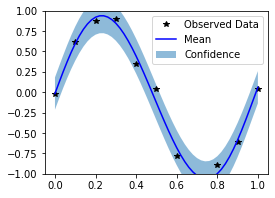

In [16]:
with torch.no_grad():
    observed_pred = likelihood(gp(x_test))
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(x_train.numpy(), y_train.numpy(), "k*")
    # Plot predictive means as blue line
    ax.plot(x_test.squeeze().numpy(), observed_pred.mean.numpy(), "b")
    # Shade between the lower and upper confidence bounds
    ax.fill_between(x_test.squeeze().numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-1, 1])
    ax.legend(["Observed Data", "Mean", "Confidence"])

In [17]:
@bm.random_variable
def outputscale():
    return dist.Uniform(torch.tensor(1.0), torch.tensor(2.0))


@bm.random_variable
def lengthscale():
    return dist.Uniform(torch.tensor([0.01]), torch.tensor([0.5]))


@bm.random_variable
def period_length():
    return dist.Uniform(torch.tensor([0.05]), torch.tensor([2.5]))


@bm.random_variable
def noise():
    return dist.Uniform(torch.tensor([0.05]), torch.tensor([0.3]))


@bm.random_variable
def mean(batch_shape=()):
    batch_shape += (1,)
    a = -1 * torch.ones(batch_shape)
    b = torch.ones(batch_shape)
    return dist.Uniform(a, b)

In [18]:
kernel = bgp.kernels.ScaleKernel(
    base_kernel=bgp.kernels.PeriodicKernel(
        period_length_prior=period_length, lengthscale_prior=lengthscale
    ),
    outputscale_prior=outputscale,
)
likelihood = bgp.likelihoods.GaussianLikelihood(noise_prior=noise)

gp = Regression(x_train, y_train, mean, kernel, likelihood)

In [20]:
num_samples = 1 if smoke_test else 100
num_adaptive_samples = 0 if smoke_test else num_samples // 2
num_chains = 1 if smoke_test else 2

# bind the data to the forward call so it can be invoked in the likelihood
queries = [mean(), lengthscale(), period_length(), outputscale(), noise()]
gp_prior = partial(gp, x_train)
obs = {gp.likelihood(gp_prior): y_train}

nuts = bm.SingleSiteNoUTurnSampler()
samples = nuts.infer(
    queries=queries,
    observations=obs,
    num_samples=num_samples,
    num_adaptive_samples=num_adaptive_samples,
    num_chains=num_chains,
)

IndexError: too many indices for tensor of dimension 1